In [3]:
%matplotlib inline
import gc
import datetime
import math
import pandas as pd
import numpy as np

#charts
import matplotlib.pyplot as plt

#statistical modelling
import statsmodels.api as sm
from sklearn.metrics import r2_score

#regression modelling
from pystan import stan
from pystan import StanModel
from sklearn.linear_model import BayesianRidge


ModuleNotFoundError: No module named 'statsmodels'

# Data extraction and preprocessing

In [3]:
###Data extraction
#fillna and identify trend/cycle

INPUT_FILE = 'clear_data_in.csv' #Lux
df = pd.read_csv(INPUT_FILE, sep=',',index_col='date',parse_dates=['date'])

indepent_vars = []
targets = []
for i in df.columns:
    if 'uba' not in i.lower():
        indepent_vars.append(i)
    else:
        targets.append(i)
    
for target in targets:
    df[target]=df[target].fillna(method='ffill') 
    cycle, trend = sm.tsa.filters.hpfilter(df[target])
    df[target + "_cycle"] = cycle
    df[target + "_trend"] = trend

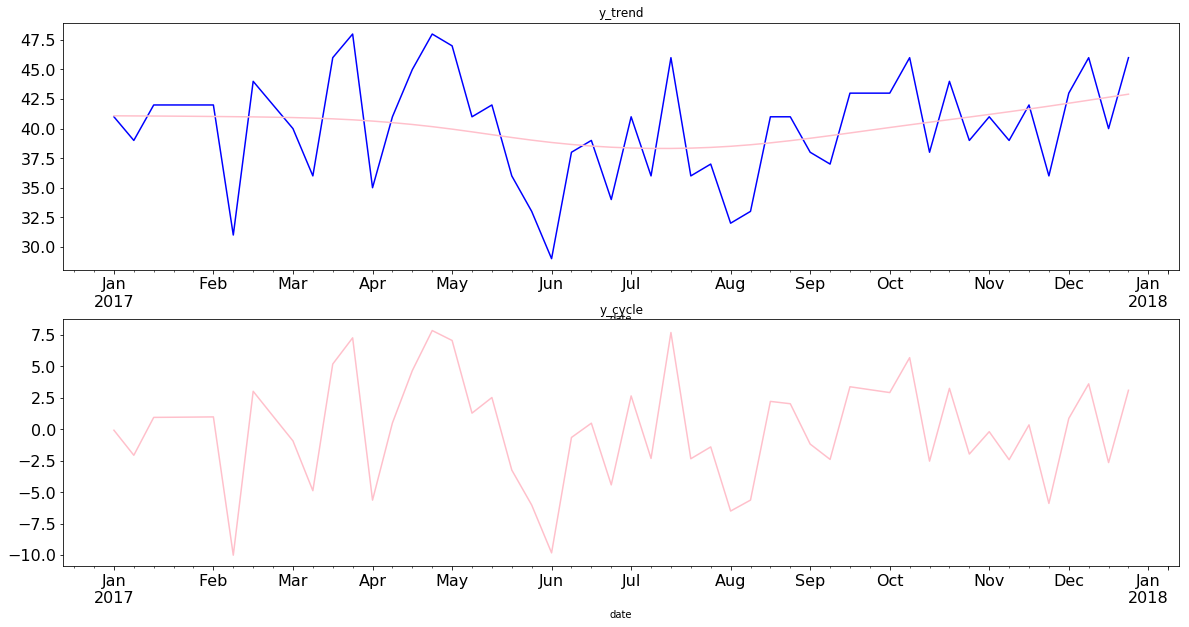

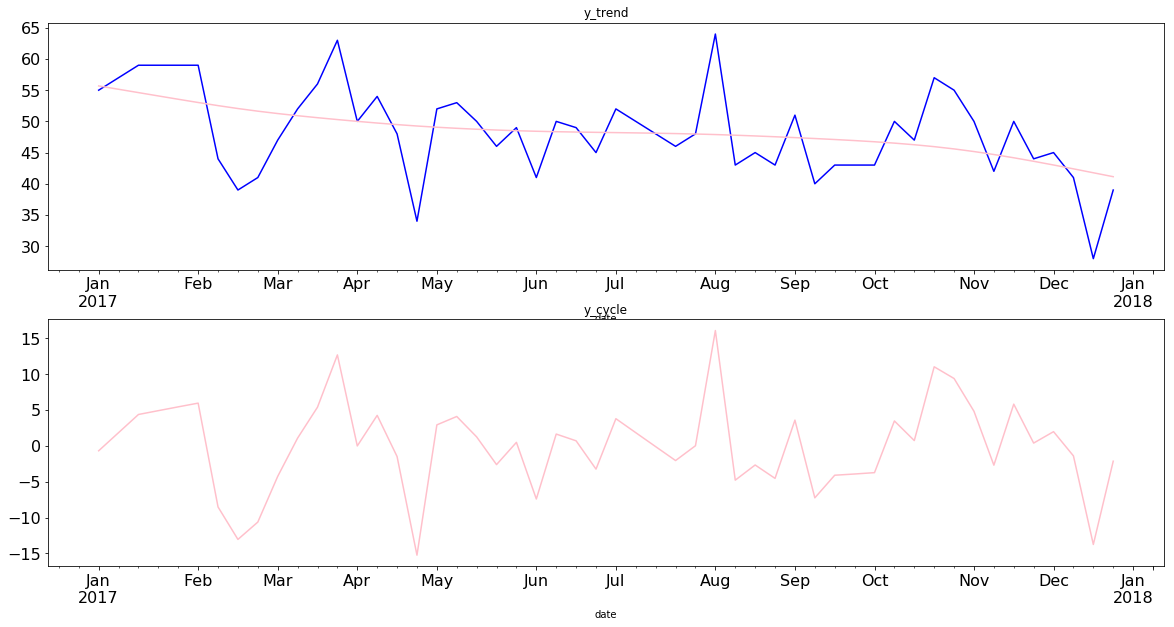

In [4]:
from data_browse_plot import plot_scatter_trend

data_browse_plot_1='data_browse_trend_cycle.jpg'
for target in targets:
    plot_scatter_trend(df[target],df[target + "_trend"],df[target + "_cycle"],data_browse_plot_1)
    plt.show()

In [5]:
#define the original var
var_media = [ 'msp.tv.female.grp', 'msp.tv.male.grp','msp.ooh.spend', 'hb.ip', 'ov.pdb.female.ip', 'ov.pdb.male.ip','content.sports.ip']
var_mediaspend = [ 'msp.tv.female.spend', 'msp.tv.male.spend', 'msp.ooh.spend', 'hb.spend','ov.pdb.female.spend', 'ov.pdb.male.spend', 'content.sports.spend']
var_nonmedia = [ 'wtd','uba.female_trend']
var_y = ['uba.female']
# var_nonmedia = [ 'wtd','uba.male_trend']
# var_y = ['uba.male']

# data extraction and preprocessing
df_v=df.ix[:,var_y+var_nonmedia+var_media]
df_mediaspend=df.ix[:,var_mediaspend]
tmp=df_mediaspend.sum()
spend_pct=[100*tmp[i]/sum(tmp) for i in range(0,len(tmp))]

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


/home/riona.zhang/python/ul/final code/util_adstock.py:16: RuntimeWarning: overflow encountered in long_scalars
  data_carried[i] = (data_in[i-1] + data_carried[i-1]) * par_carryover


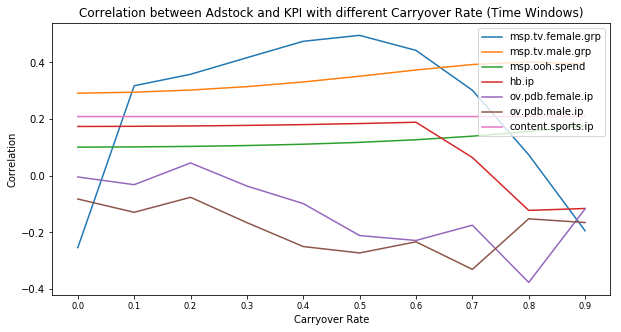

In [6]:
### glance at corr

from util_adstock import Adstock
from util_corr import auto_corr_window
from data_browse_plot import plot_scatter_corr

cr = np.array(range(10))/10
cor_results=auto_corr_window(df,var_media,var_y,cr)

fn_plotoutput_0 = 'data_browse_relative_corr.jpg'
plot_scatter_corr(cr,cor_results,var_media,fn_plotoutput_0)
plt.show()

# Simple BYS

In [7]:
######################################################
# Random Searching
######################################################
from util_simple_Bayes_calc import rand_search_lm

funcs="Simple Power"
n_sim=1000
%time my_coefs,my_scores,par_list=rand_search_lm(funcs,df,var_y,var_media,var_nonmedia,n_sim)


/opt/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 12.9 s, sys: 10.3 ms, total: 12.9 s
Wall time: 16.4 s


In [8]:
######################################################
# filter the candidates with higher r2 and coef values
######################################################
from par_title_create import par_title
from util_candid_filter import results_filter

n_mcmc=500
%time df_bys_candidate_filtered=results_filter(funcs,my_coefs,my_scores,par_list,var_media,var_nonmedia,n_mcmc)


CPU times: user 13.6 ms, sys: 29 µs, total: 13.7 ms
Wall time: 31.3 ms


# MCMC(PYSTAN Version)

In [9]:
import pickle
%time my_sm = pickle.load(open('mcmc_pystan.pkl', 'rb'))

CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 50.6 ms


In [11]:
# calculate mcmc
from uitl_mcmc_calc import get_coef_pys

df_v=df.ix[:,var_y+var_nonmedia+var_media]
start_date = '2017-01-01';end_date = '2017-12-30';cal_mean=True

idx_start=0
idx_end=500
#method 1:随机生成
# par_list=pd.read_csv(fn_decayinput, sep=',',header=None)
# par_list=ram_par_create(funcs,df,var_media,n=1000)
# var_par_list=par_list[idx_start:idx_end,:]

#method 2:简单贝叶斯精简后
var_par_list=df_bys_candidate_filtered.iloc[idx_start:idx_end,:-(len(var_nonmedia)+len(var_media)+2)].values

r2,dw,contr_pct,X_summary,y_summary,act_index=get_coef_pys(df_v,var_y,var_nonmedia,var_media,var_par_list,funcs,start_date,end_date,cal_mean)

0 2018-05-29 15:34:13.167933


/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


AttributeError: 'StanModel' object has no attribute 'fit_class'

In [9]:
import pystan

In [11]:
pystan.VERSION

AttributeError: module 'pystan' has no attribute 'VERSION'

In [ ]:
#优选top50% 候选模型
from util_candid_filter import results_ranking

roi_idx=np.divide(contr_pct,spend_pct);fnl_n=200
fnl_r2,fnl_dw,fnl_var_par_list,fnl_roi_idx,fnl_contr_pct,rnk = results_ranking(funcs,r2,dw,var_par_list,roi_idx,contr_pct,var_media,fnl_n)

contr_pct_weighted=np.dot(fnl_r2,fnl_contr_pct)/np.sum(fnl_r2)
roi_idx_weighted=np.divide(contr_pct_weighted,spend_pct)

fnl_X_summary=np.zeros((len(rnk),X_summary.shape[1],X_summary.shape[2]))
fnl_y_summary=np.zeros((len(rnk),y_summary.shape[1],y_summary.shape[2]))
for i, txt in enumerate(rnk):
    fnl_X_summary[i]=X_summary[txt]
    fnl_y_summary[i]=y_summary[txt]

In [ ]:
#output and plot
from util_plot import plot_scatter_ROI,plot_bar_ROI,plot_scatter_curve
from util_cluster import Cluster

fn_dataoutput_1='pystan_test_data_relative_ROI_out_uba.csv'
fn_dataoutput_2='pystan_test_data_reponse_curve_out_uba.csv'
fn_plotoutput_1='pystan_test_data_relative_ROI_out_uba.jpg'
fn_plotoutput_1_1='pystan_test_data_relative_ROI_index_out_uba.jpg'
fn_plotoutput_2='pystan_test_data_reponse_curve_out_uba.jpg'

In [ ]:
#result out 平均
#EI
tmp_1=np.column_stack((fnl_r2,fnl_dw,fnl_var_par_list,fnl_roi_idx,fnl_contr_pct))
tmp_1=np.vstack([tmp_1,np.zeros((tmp_1.shape[1]))])
tmp_1[-1,-2*len(var_media):]= list(roi_idx_weighted)+list(contr_pct_weighted)
np.savetxt(funcs+"_"+fn_dataoutput_1, tmp_1, delimiter=',',fmt='%1.4f') 

#curve
tmp_2 = fnl_X_summary[0]
for array in fnl_y_summary:
    tmp_2 = np.concatenate((tmp_2,array))
np.savetxt(funcs+"_"+fn_dataoutput_2, tmp_2.T, delimiter=',',fmt='%1.4f')

#plot
fnl_X_summary_m = fnl_X_summary.mean(axis=0)
fnl_y_summary_m = fnl_y_summary.mean(axis=0)
cluster = Cluster(fnl_X_summary_m,fnl_y_summary_m,k=5) #k调整分割区间数量

plot_scatter_ROI(spend_pct,contr_pct_weighted,var_media,fn_plotoutput_1)
plot_bar_ROI(roi_idx_weighted,var_media,fn_plotoutput_1_1)
plot_scatter_curve(fnl_X_summary_m,fnl_y_summary_m,cluster,var_media,act_index,fn_plotoutput_2)

plt.show()

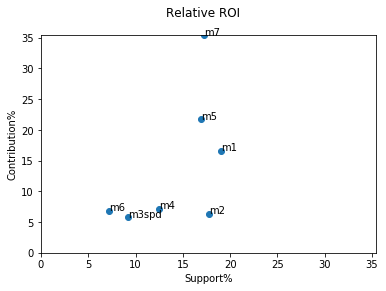

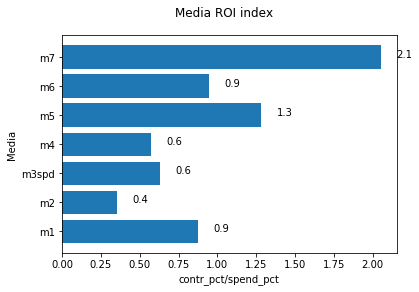

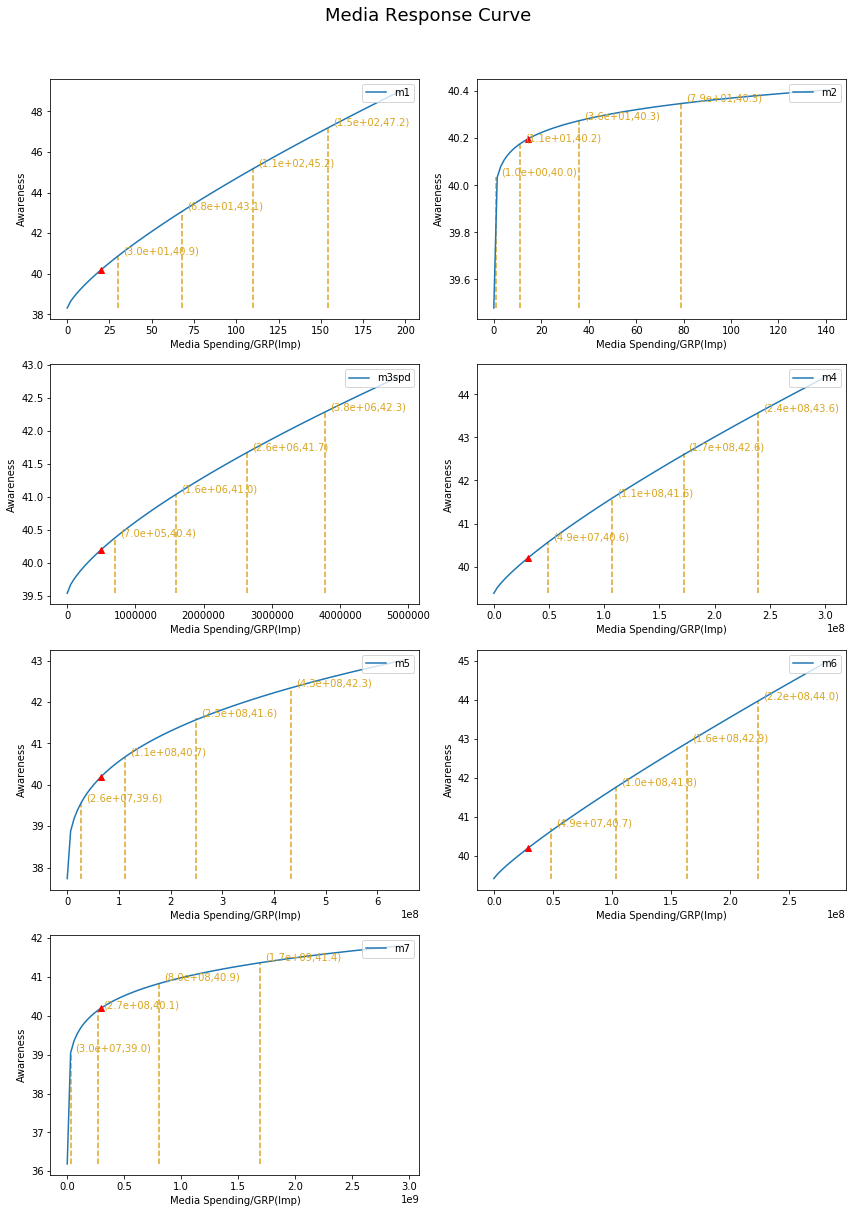

In [22]:
#单个模型结果输出

#plot
iteration=0  #调节参数iteration选择不同的模型序列号
cluster = Cluster(fnl_X_summary[iteration],fnl_y_summary[iteration],k=5)

plot_scatter_ROI(spend_pct,fnl_contr_pct[iteration],var_media,fn_plotoutput_1)
plot_bar_ROI(fnl_roi_idx[iteration],var_media,fn_plotoutput_1_1)
plot_scatter_curve(fnl_X_summary[iteration],fnl_y_summary[iteration],cluster,var_media,act_index,fn_plotoutput_2)
plt.show()

In [23]:
#data
tmp = np.concatenate((X_summary[iteration],y_summary[iteration]))
column_title = ["X_"+ var for var in var_media]+["y_"+ var for var in var_media] 
df_out = pd.DataFrame(tmp.T,columns=column_title) 
df_out.to_csv("Rank_"+str(iteration)+"_"+funcs+"_"+fn_dataoutput_2) 